# CNN Model with VGG-16 GRADCAM


In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


## Pre-processing the Images

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(),      # Data Augmentation
    #transforms.RandomRotation(10),          # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/CNN-CNR/Datasets/final-200-train-test/test', transform=transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)



## Testing

In [3]:
import os
import glob
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import plotly.express as px
from torchvision.models import VGG16_Weights


In [4]:
def plot_per_class_accuracy_continuous(per_class_accuracy, class_names, color_scale='RdYlBu'):
    """
    Creates an interactive bar chart for per-class accuracy with a continuous color scale.

    Args:
        per_class_accuracy (list or array): Accuracy for each class.
        class_names (list): Names of the classes.
        color_scale (str or list, optional): Plotly color scale to use. Default is 'RdYlBu'.
    """
    # Create a DataFrame
    df = pd.DataFrame({
        'Class': class_names,
        'Accuracy': per_class_accuracy
    })

    fig = px.bar(
        df,
        x='Class',
        y='Accuracy',
        color='Accuracy',
        color_continuous_scale=color_scale,
        hover_data={'Class': True, 'Accuracy': ':.2f'},
        labels={'Accuracy': 'Accuracy'},
        title='Per-Class Accuracy',
        range_y=[0, 1]
    )

    fig.update_layout(
        xaxis_title='Classes',
        yaxis_title='Accuracy',
        coloraxis_colorbar=dict(
            title="Accuracy",
            tickvals=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
            ticktext=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]
        )
    )

    fig.update_traces(
        hovertemplate='<b>%{x}</b><br>Accuracy: %{y:.2f}<extra></extra>'
    )

    fig.show()


def group_classes_by_recall(per_class_recall, class_names, bins=None, plot=True):
    """
    Groups the number of classes based on their recall into specified ranges.

    Args:
        per_class_recall (list or array): Recall values for each class.
        class_names (list): List of class names corresponding to the recall values.
        bins (list of tuples, optional): List of (min, max) tuples defining recall ranges.
                                         Defaults to predefined ranges:
                                         [(0.9, 1.0), (0.8, 0.89), (0.7, 0.79), (0.6, 0.69), (0.0, 0.59)]
        plot (bool, optional): Whether to plot the group counts. Defaults to True.

    Returns:
        dict: A dictionary with bin labels as keys and counts as values.
    """
    if bins is None:
        bins = [
            (0.9, 1.0),
            (0.8, 0.899),
            (0.7, 0.799),
            (0.6, 0.699),
            (0.5, 0.599),
            (0.4, 0.499),
            (0.3, 0.399),
            (0.2, 0.299),
            (0.1, 0.199),
            (0.0, 0.1)
        ]

    # Define bin labels
    bin_labels = [
        '0.9 - 1.0',
        '0.8 - 0.899',
        '0.7 - 0.799',
        '0.6 - 0.699',
        '0.5 - 0.599',
        '0.4 - 0.499',
        '0.3 - 0.399',
        '0.2 - 0.299',
        '0.1 - 0.199',
        '< 0.1'
    ]

    # Initialize counts
    bin_counts = {label: 0 for label in bin_labels}
    bin_class_names = {label: [] for label in bin_labels}

    # Assign each class to a bin
    for recall, class_name in zip(per_class_recall, class_names):
        placed = False
        for (min_val, max_val), label in zip(bins, bin_labels):
            if min_val <= recall <= max_val:
                bin_counts[label] += 1
                bin_class_names[label].append(class_name)
                placed = True
                break
        if not placed:
            print(f"Recall value {recall} for class '{class_name}' does not fit into any bin.")

    # Print the counts
    print("\nNumber of classes in each recall range:")
    for label in bin_labels:
        print(f"{label}: {bin_counts[label]}")

    return bin_counts, bin_class_names

In [5]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(conf_matrix, class_names, save_path=None):

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved at: {save_path}")

    plt.show()

    plt.close()


def plot_true_false_positive(conf_matrix, class_names, save_path=None):

    total_set = conf_matrix.sum(axis=1)  # Total images per class
    true_positive = conf_matrix.diagonal()  # True positives
    false_positive = conf_matrix.sum(axis=0) - conf_matrix.diagonal()  # False positives

    plt.figure(figsize=(16, 8))
    x = np.arange(len(class_names))  # Indices for classes
    width = 0.3  # Width of each bar

    plt.bar(x - width, total_set, width=width, label='Total Set', color='blue')
    plt.bar(x, true_positive, width=width, label='True Positives (TP)', color='green')
    plt.bar(x + width, false_positive, width=width, label='False Positives (FP)', color='red')

    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.ylabel('Count')
    plt.xlabel('Classes')
    plt.title('True Positives and False Positives per Class')
    plt.legend(loc='upper right')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"True/False Positives chart saved at: {save_path}")

    plt.show()

    plt.close()


def plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=0.8, save_path=None):

    plt.figure(figsize=(12, 6))
    plt.bar(class_names, per_class_recall, color='c')
    plt.axhline(y=accuracy_threshold, color='r', linestyle='--', label='Threshold')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Classes')
    plt.ylabel('Recall')
    plt.title('Recall per Class')
    plt.legend()
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Per-class recall chart saved at: {save_path}")


    plt.show()

    plt.close()



def write_results_to_txt(save_path: str,model_name: str, model_path: str, device: torch.device, overall_accuracy: float, precision: float, recall: float, f1: float, class_report: str,
    per_class_accuracy: list, class_names: list, zero_pred_classes: list, memory_used: float, execution_time: float, resources):

    txt_path = os.path.join(save_path, f"{model_name}.txt")
    with open(txt_path, 'w') as f:
        f.write(f"Model Evaluation Results\n")
        f.write(f"Model Path: {model_path}\n")
        f.write(f"Device: {device}\n\n")

        f.write(f"Overall Accuracy: {overall_accuracy:.4f}\n")
        f.write(f"Weighted Precision: {precision:.4f}\n")
        f.write(f"Weighted Recall: {recall:.4f}\n")
        f.write(f"Weighted F1-Score: {f1:.4f}\n\n")

        f.write("Classification Report:\n")
        f.write(class_report + "\n")

        f.write("Per-Class Accuracy:\n")
        for idx, class_name in enumerate(class_names):
            f.write(f" - {class_name}: {per_class_accuracy[idx]:.4f}\n")

        if zero_pred_classes:
            f.write("\nClasses with no predictions:\n")
            for class_name in zero_pred_classes:
                f.write(f" - {class_name}\n")
        else:
            f.write("\nAll classes have at least one prediction.\n")

        f.write(f"\nGPU memory used during the test: {memory_used:.2f} MB\n")
        f.write(f"Execution time: {execution_time:.2f} seconds\n")
        f.write(f"Resource used(execution_time / memory_used): {resources:.2f}\n")

    print(f"\nResults saved in: {txt_path}")

## GradCam

In [6]:
import os
import torch
from torch.autograd import Function
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Make sure tqdm is imported for the progress bar
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

class GradCAM:
    def __init__(self, model, target_layer):
        """
        Initializes Grad-CAM with the model and target convolutional layer.

        Args:
            model (nn.Module): The neural network model.
            target_layer (str): The name of the target convolutional layer.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        """
        Registers forward and backward hooks to capture activations and gradients.
        """
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                module.register_forward_hook(self.save_activation)
                module.register_backward_hook(self.save_gradient)
                break
        else:
            raise ValueError(f"Layer '{self.target_layer}' not found in the model.")

    def save_activation(self, module, input, output):
        """
        Hook to save activations from the forward pass.

        Args:
            module: The module being hooked.
            input: Input to the module.
            output: Output from the module.
        """
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        """
        Hook to save gradients from the backward pass.

        Args:
            module: The module being hooked.
            grad_input: Gradients flowing into the module.
            grad_output: Gradients flowing out of the module.
        """
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self, input_tensor, class_idx=None):
        """
        Generates the Grad-CAM heatmap for a specific class.

        Args:
            input_tensor (torch.Tensor): Preprocessed input image tensor.
            class_idx (int, optional): Target class index. Defaults to the predicted class.

        Returns:
            np.ndarray: Normalized Grad-CAM heatmap.
        """
        self.model.zero_grad()
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        target = output[:, class_idx]
        target.backward(retain_graph=True)

        # Global average pooling of gradients
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight the activations by the gradients
        for i in range(self.activations.shape[1]):
            self.activations[:, i, :, :] *= pooled_gradients[i]

        # Average the weighted activations
        heatmap = torch.mean(self.activations, dim=1).squeeze()

        # Apply ReLU and normalize
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap) if torch.max(heatmap) != 0 else torch.ones_like(heatmap)

        return heatmap.cpu().numpy()



In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def generate_and_visualize_gradcam(model, gradcam, images, labels, preds, class_names, mean, std, save_path=None):
    """
    Generates and visualizes Grad-CAM heatmaps for a set of images, saving them into
    'true_predicted' and 'false_predicted' directories based on prediction correctness.

    Args:
        model (nn.Module): The neural network model.
        gradcam (GradCAM): An instance of the GradCAM class.
        images (list of torch.Tensor): List of input image tensors.
        labels (list of int): List of true class indices.
        preds (list of int): List of predicted class indices.
        class_names (list): List of class names.
        mean (list): Mean values for denormalization.
        std (list): Standard deviation values for denormalization.
        save_path (str, optional): Base directory path to save the visualizations.
                                   Images will be saved in 'true_predicted' and 'false_predicted' subdirectories.
                                   Defaults to None.
    """
    # Define subdirectories for correct and incorrect predictions
    correct_dir = os.path.join(save_path, 'true_predicted') if save_path else None
    incorrect_dir = os.path.join(save_path, 'false_predicted') if save_path else None

    if save_path:
        os.makedirs(correct_dir, exist_ok=True)
        os.makedirs(incorrect_dir, exist_ok=True)

    for idx in range(len(images)):
        input_tensor = images[idx].unsqueeze(0).to(next(model.parameters()).device)
        label = labels[idx]
        pred = preds[idx]

        # Generate Grad-CAM heatmap
        heatmap = gradcam.generate_heatmap(input_tensor, class_idx=pred)

        # Denormalize the image
        img = denormalize(images[idx].clone(), mean, std).permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)

        # Resize heatmap to match the image size
        heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
        heatmap_resized = np.uint8(255 * heatmap_resized)
        heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

        # Overlay heatmap on the image
        #superimposed_img = heatmap_color * 0.4 + (img * 255).astype(np.uint8)
        # Converti l'immagine originale in valori interi tra 0 e 255
        img_uint8 = (img * 255).astype(np.uint8)

        # Sovrapponi la heatmap sull'immagine
        superimposed_img = cv2.addWeighted(heatmap_color, 0.4, img_uint8, 0.6, 0)

        # Determine if prediction is correct
        is_correct = pred == label

        # Select the appropriate save directory
        if is_correct:
            target_dir = correct_dir
            status = 'correct'
        else:
            target_dir = incorrect_dir
            status = 'incorrect'

        if save_path:
            # Define the filename
            save_file = os.path.join(target_dir, f'gradcam_{idx+1}_{status}.png')
        else:
            save_file = None  # Will display the plot instead

        # Plot the results
        plt.figure(figsize=(12, 4))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title(f'Original Image\nActual: {class_names[label]}')
        plt.axis('off')

        # Heatmap
        plt.subplot(1, 3, 2)
        sns.heatmap(heatmap_resized, cmap='jet', cbar=False)
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')

        # Image with Heatmap Overlay
        plt.subplot(1, 3, 3)
        plt.imshow(superimposed_img)
        plt.title(f'Grad-CAM Overlay\nPredicted: {class_names[pred]}')
        plt.axis('off')

        plt.tight_layout()

        # Save or show the plot
        if save_path:
            plt.savefig(save_file)
            plt.close()
            print(f'Saved Grad-CAM visualization to: {save_file}')
        else:
            plt.show()


def denormalize(tensor, mean, std):
    """
    Denormalizes a tensor using the provided mean and std.

    Args:
        tensor (torch.Tensor): Normalized image tensor.
        mean (list): Mean values for each channel.
        std (list): Standard deviation values for each channel.

    Returns:
        torch.Tensor: Denormalized image tensor.
    """
    tensor = tensor.clone()
    for c in range(tensor.size(0)):
        tensor[c] = tensor[c] * std[c] + mean[c]
    return tensor

In [8]:
from tqdm import tqdm
import seaborn as sns
import time
import psutil

def test_model_with_gradcam(model_path,
                            model_architecture=None,
                            test_loader=None,
                            device=None,
                            class_names=None,
                            accuracy_threshold=0.8,
                            save_path=None,
                            gradcam_layer='features.29',  # Target layer for VGG16
                            num_images=200):
    """
    Loads a trained model, evaluates it on the test dataset, and visualizes Grad-CAM for selected images.

    Args:
        model_path (str): Path to the model file (.pth).
        model_architecture (nn.Module): The model architecture.
        test_loader (DataLoader): DataLoader for the test dataset.
        device (torch.device, optional): Device for computations. Defaults to CUDA if available.
        class_names (list): List of class names.
        accuracy_threshold (float, optional): Threshold to determine bar color in the plot.
        save_path (str, optional): Path to save the results and visualizations.
        gradcam_layer (str): Name of the target convolutional layer for Grad-CAM.
        num_images (int): Number of images to visualize with Grad-CAM.

    Returns:
        dict: Dictionary containing evaluation metrics and per-class recall.
    """
    # Validate inputs
    if model_architecture is None:
        raise ValueError("model_architecture must be provided.")

    if test_loader is None:
        raise ValueError("test_loader must be provided.")

    if class_names is None:
        raise ValueError("class_names must be provided.")

    if not os.path.isfile(model_path):
        raise FileNotFoundError(f"The specified model_path does not exist or is not a file: {model_path}")

    if device.type == "cuda":
        before_memory = torch.cuda.memory_allocated(device)
    else:
        process = psutil.Process(os.getpid())
        before_memory = process.memory_info().rss

    # Misurazione tempo di inizio
    start_time = time.time()



    model_architecture.to(device)
    model_architecture.eval()

    # Initialize Grad-CAM
    gradcam = GradCAM(model_architecture, target_layer=gradcam_layer)

    all_preds = []
    all_labels = []

    # Evaluate the model
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_architecture(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Misurazione tempo di fine
    end_time = time.time()

    # Misurazione memoria dopo il test
    if device.type == "cuda":
        after_memory = torch.cuda.memory_allocated(device)
        peak_memory = torch.cuda.max_memory_allocated(device)
        memory_used = (peak_memory - before_memory) / (1024 ** 2)  # In MB
    else:
        process = psutil.Process(os.getpid())
        after_memory = process.memory_info().rss
        memory_used = (after_memory - before_memory) / (1024 ** 2)  # In MB

    overall_accuracy = accuracy_score(all_labels, all_preds)
    print(f'\nOverall Accuracy: {overall_accuracy:.4f}')

    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    print(f'Weighted Precision: {precision:.4f}')
    print(f'Weighted Recall: {recall:.4f}')
    print(f'Weighted F1-Score: {f1:.4f}')

    conf_matrix = confusion_matrix(all_labels, all_preds)

    class_report = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    report_dict = classification_report(all_labels, all_preds, target_names=class_names, zero_division=0, output_dict=True)
    per_class_recall = [report_dict[class_name]['recall'] for class_name in class_names]

    with np.errstate(divide='ignore', invalid='ignore'):
        per_class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
        per_class_accuracy = np.nan_to_num(per_class_accuracy)

    print('Per-Class Accuracy:')
    for idx, class_name in enumerate(class_names):
        print(f' - {class_name}: {per_class_accuracy[idx]:.4f}')

    predictions_per_class = conf_matrix.sum(axis=0)
    zero_pred_classes = [class_names[i] for i, count in enumerate(predictions_per_class) if count == 0]

    if zero_pred_classes:
        print(f"\nClasses with no predictions: {zero_pred_classes}")
    else:
        print("\nAll classes have at least one prediction.")

    execution_time = end_time - start_time
    resources = execution_time * memory_used if memory_used > 0 else float('inf')  # Opzionale

    if save_path is not None:
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        model_name = os.path.splitext(os.path.basename(model_path))[0]
        conf_matrix_path = os.path.join(save_path, f"{model_name}_conf_matrix.png")
        bar_plot_path = os.path.join(save_path, f"{model_name}_true_false_positive.png")
        recall_plot_path = os.path.join(save_path, f"{model_name}_recall_plot.png")


        write_results_to_txt(save_path=save_path, model_name=model_name, model_path=model_path, device=device, overall_accuracy=overall_accuracy,
            precision=precision, recall=recall, f1=f1, class_report=class_report, per_class_accuracy=per_class_accuracy, class_names=class_names,
            zero_pred_classes=zero_pred_classes, memory_used=memory_used, execution_time=execution_time, resources=resources )


        plot_confusion_matrix(conf_matrix, class_names, save_path=conf_matrix_path)
        plot_true_false_positive(conf_matrix, class_names, save_path=bar_plot_path)
        plot_per_class_recall(per_class_recall, class_names, accuracy_threshold=accuracy_threshold, save_path=recall_plot_path)


    # Select images for Grad-CAM visualization (mix of correct and incorrect predictions)
    correct_images = []
    correct_labels = []
    correct_preds = []
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_architecture(inputs)
            _, preds = torch.max(outputs, 1)

            max_correct = 50  # Numero massimo di immagini correct
            max_incorrect = 100

            for i in range(inputs.size(0)):
                if preds[i].item() == labels[i].item():
                    if len(correct_images) < max_correct:
                        correct_images.append(inputs[i].cpu())
                        correct_labels.append(labels[i].item())
                        correct_preds.append(preds[i].item())
                else:
                    if len(incorrect_images) < max_incorrect:
                        incorrect_images.append(inputs[i].cpu())
                        incorrect_labels.append(labels[i].item())
                        incorrect_preds.append(preds[i].item())


    print(f"Number of correct images: {len(correct_images)}")
    print(f"Number of incorrect images: {len(incorrect_images)}")
    # Combine correct and incorrect images
    images_visualize = correct_images + incorrect_images
    labels_visualize = correct_labels + incorrect_labels
    preds_visualize = correct_preds + incorrect_preds

    # Define normalization parameters (modify if different)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Generate and visualize Grad-CAM
    generate_and_visualize_gradcam(
        model=model_architecture,
        gradcam=gradcam,
        images=images_visualize,
        labels=labels_visualize,
        preds=preds_visualize,
        class_names=class_names,
        mean=mean,
        std=std,
        save_path=os.path.join(save_path, 'gradcam_visualizations') if save_path else None
    )

    #compute_classification_statistics(labels, preds, class_names)

    results = {
        'overall_accuracy': overall_accuracy,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'per_class_recall': per_class_recall,
        'per_class_accuracy': per_class_accuracy,
        'zero_pred_classes': zero_pred_classes
    }

    print(f"\nGPU memory used during the test: {memory_used:.2f} MB")  # GPU memory used during the test in MB
    print(f"Execution time: {execution_time:.2f} seconds")  # Total execution time in seconds
    print(f"Resource used(execution_time / memory_used): {resources:.2f}")  # Opzionale

    return results

## TESTING

In [9]:
def load_architecture_vgg16(model_path,dataset):

  class_names = test_dataset.classes

  # Define model architecture (VGG16)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model_architecture = models.vgg16(weights='VGG16_Weights.DEFAULT')
  num_classes = len(class_names)
  model_architecture.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
  model_architecture.to(device)

  if model_path:
      model_architecture.load_state_dict(torch.load(model_path, map_location=device))

  return model_architecture, class_names, device

In [11]:
model_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16/vgg16_model_01_25_2025_15_44_0.95125.pth'

save_path = '/content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam'

model_architecture,class_names, device = load_architecture_vgg16(model_path,test_dataset)

<ipython-input-9-e9a286fdefc6>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_architecture.load_state_dict(torch.load(model_path, map_location=device))


Evaluating: 100%|██████████| 32/32 [07:36<00:00, 14.26s/it]



Overall Accuracy: 0.9160
Weighted Precision: 0.9178
Weighted Recall: 0.9160
Weighted F1-Score: 0.9141

Classification Report:
                                precision    recall  f1-score   support

    Asterionellopsis glacialis       0.95      0.97      0.96        40
        Bacteriastrum furcatum       0.94      0.85      0.89        40
        Bacteriastrum jadranum       0.95      1.00      0.98        40
          Cerataulina pelagica       0.82      1.00      0.90        40
           Chaetoceros diadema       0.84      0.90      0.87        40
          Chaetoceros diversus       0.91      0.97      0.94        40
          Chaetoceros socialis       0.86      0.93      0.89        40
              Chaetoceros spp.       0.79      0.57      0.67        40
      Chaetoceros tortissimius       0.88      0.93      0.90        40
      Cylindrotheca closterium       0.87      1.00      0.93        40
   Dactyliosolen fragilissimus       0.95      1.00      0.98        40
        

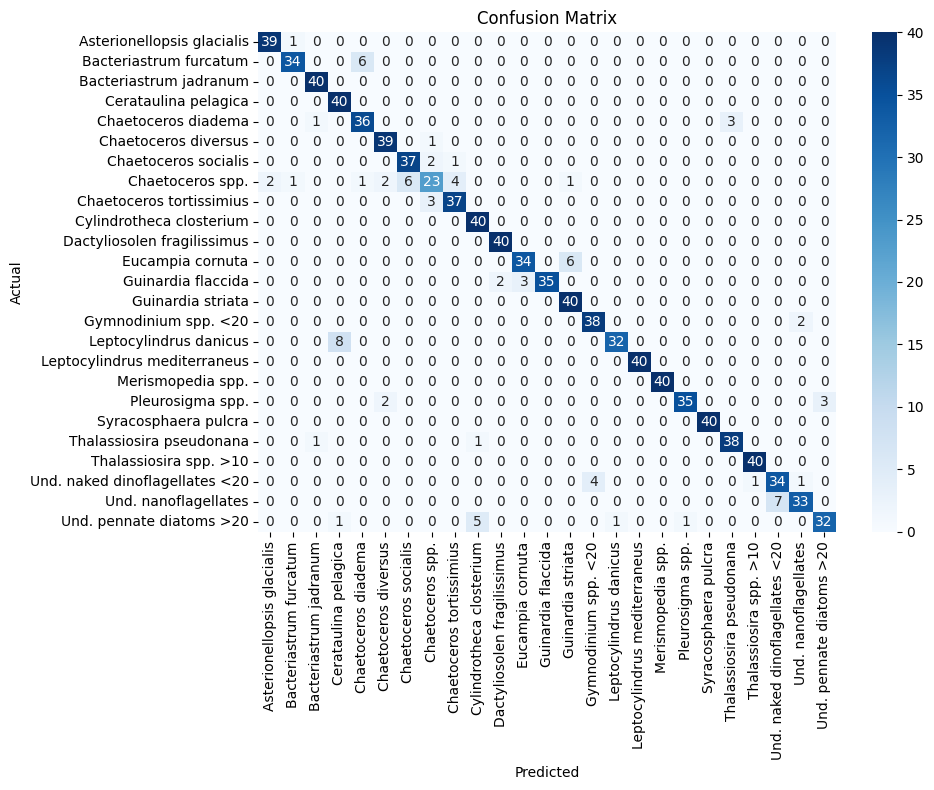

True/False Positives chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/vgg16_model_01_25_2025_15_44_0.95125_true_false_positive.png


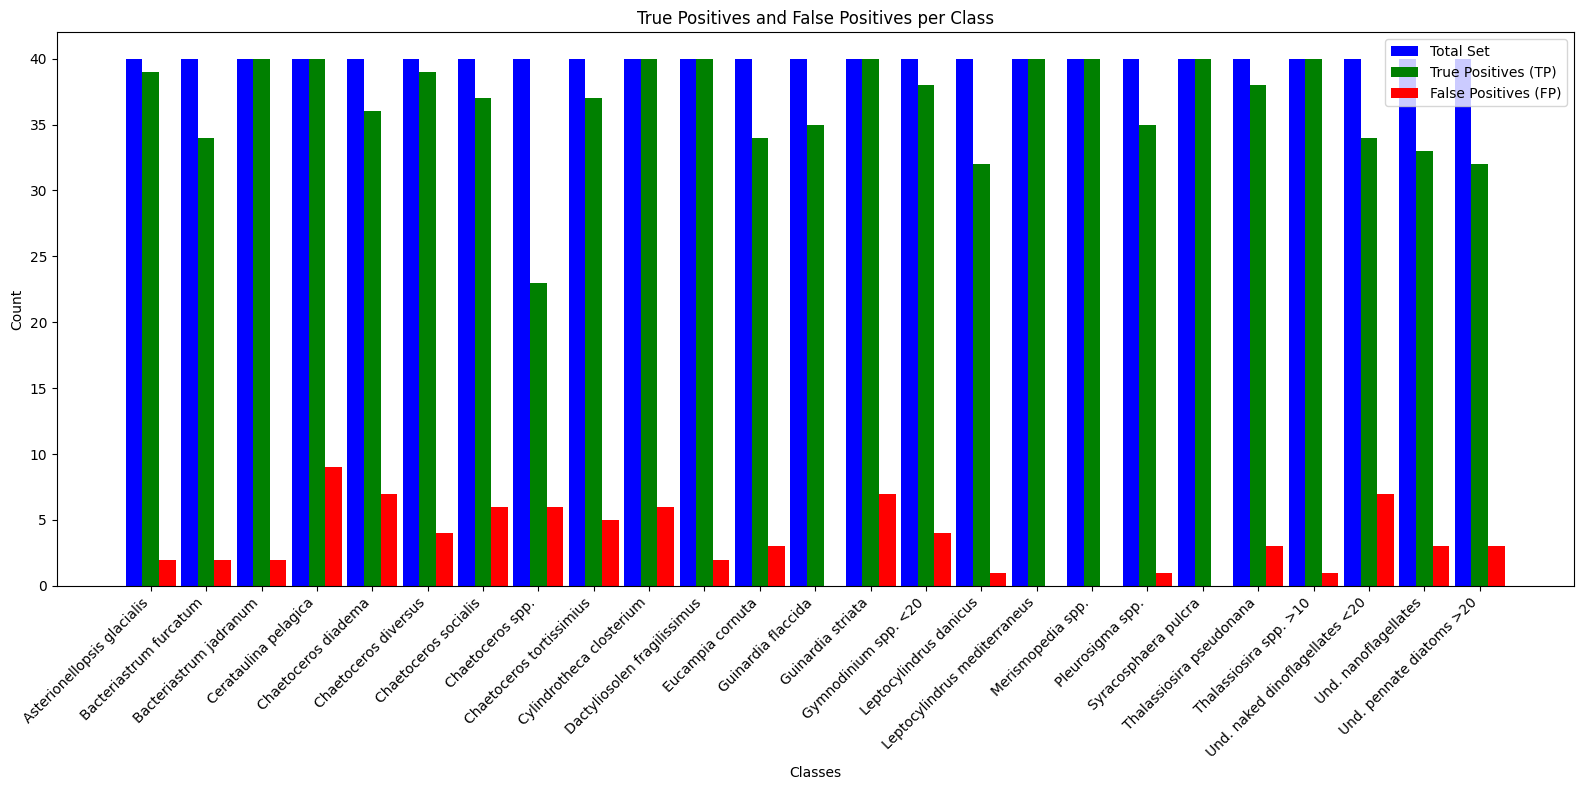

Per-class recall chart saved at: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/vgg16_model_01_25_2025_15_44_0.95125_recall_plot.png


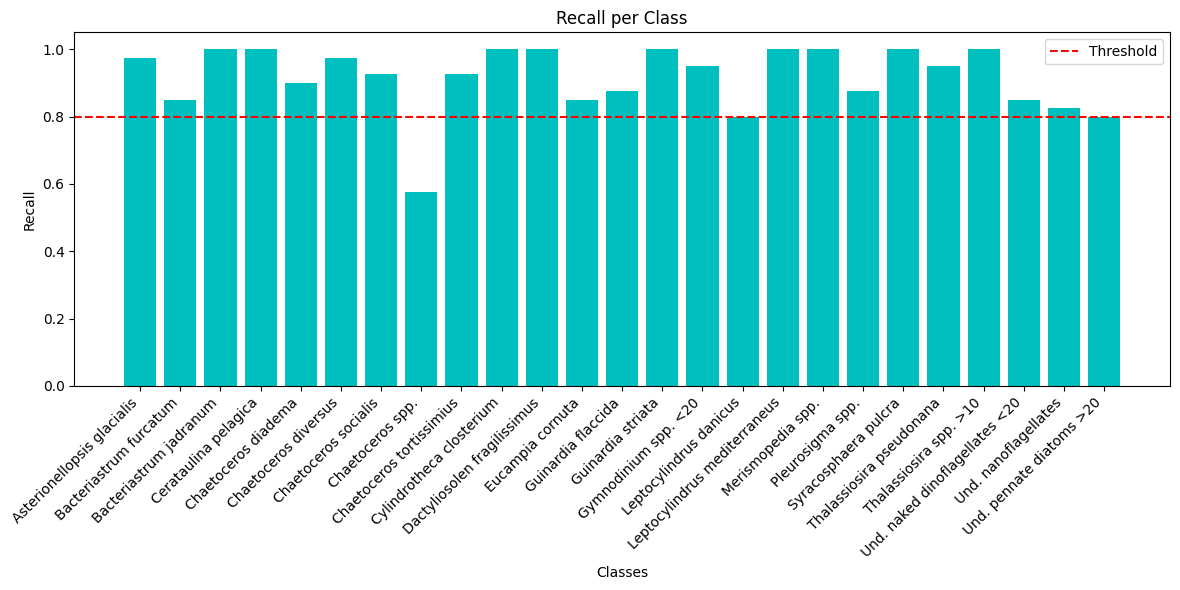

Number of correct images: 50
Number of incorrect images: 84
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_predicted/gradcam_1_correct.png
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_predicted/gradcam_2_correct.png
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_predicted/gradcam_3_correct.png
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_predicted/gradcam_4_correct.png
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_predicted/gradcam_5_correct.png
Saved Grad-CAM visualization to: /content/drive/MyDrive/CNN-CNR/Models/final-model-200/vgg16-grad-cam/gradcam_visualizations/true_

In [12]:
import warnings
warnings.filterwarnings('ignore')


# Evaluate the model and visualize Grad-CAM
results = test_model_with_gradcam(
    model_path=model_path,
    model_architecture=model_architecture,
    test_loader=test_loader,
    device=device,
    class_names=class_names,
    accuracy_threshold=0.8,
    save_path=save_path,
    gradcam_layer='features.29',  # Target layer for VGG16
    num_images=200  # Number of images to visualize with Grad-CAM
)



In [ ]:
import os
from pathlib import Path

def count_images_in_path(path, recursive=False):

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.tif', '.webp'}

    path = Path(path)

    if not path.exists():
        raise FileNotFoundError(f"The specified path does not exist: {path}")

    if not path.is_dir():
        raise NotADirectoryError(f"The specified path is not a directory: {path}")


    if recursive:
        files = path.rglob('*')
    else:
        files = path.glob('*')

    count = 0
    for file in files:
        if file.is_file() and file.suffix.lower() in image_extensions:
            count += 1

    return count


In [ ]:
import os

# Paths to the Grad-CAM visualization directories
save_path = '/content/drive/MyDrive/CNN-CNR/Models/4-layers/grad-cam/gradcam_visualizations'
true_predicted_dir = os.path.join(save_path, 'true_predicted')
false_predicted_dir = os.path.join(save_path, 'false_predicted')

# Count images in 'true_predicted' directory
try:
    true_count = count_images_in_path(true_predicted_dir, recursive=False)
    print(f"Number of correctly predicted images: {true_count}")
except (FileNotFoundError, NotADirectoryError) as e:
    print(e)

# Count images in 'false_predicted' directory
try:
    false_count = count_images_in_path(false_predicted_dir, recursive=False)
    print(f"Number of incorrectly predicted images: {false_count}")
except (FileNotFoundError, NotADirectoryError) as e:
    print(e)


The specified path does not exist: /content/drive/MyDrive/CNN-CNR/Models/4-layers/grad-cam/gradcam_visualizations/true_predicted
The specified path does not exist: /content/drive/MyDrive/CNN-CNR/Models/4-layers/grad-cam/gradcam_visualizations/false_predicted
